In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import flax.linen as nn
import matplotlib.pyplot as plt
from flax.linen.activation import softmax
from einops import rearrange
from jax import random
from jax.example_libraries import optimizers
import optax
import sys
import seaborn as sns

In [2]:
# MHSA attention layer
class Attention(nn.Module):

    scale_exp: jnp.float32
    dim: int
    heads: int
    
    def setup(self):
        
        self.c = 1.5 - self.scale_exp # exponent for the scale factor
        kif_qk = nn.initializers.normal(stddev = self.dim**(self.c - 0.5) ) # possibly needs to be scaled with N
        kif_v =  nn.initializers.normal(stddev = 1.0 ) # O_N(1) entries
        # computes key, query, value
        self.qk_layer = nn.Dense(features = 2 * self.heads * self.dim, kernel_init = kif_qk)
        self.v_layer = nn.Dense(features = self.heads * self.dim, kernel_init = kif_v)
        return
    
    def __call__(self,inputs):
        
        qk = self.qk_layer(inputs) / self.heads**(0.5) / self.dim**(self.c) / jnp.sqrt(2.0)
        qk = rearrange( qk, 'b l (h d) -> b h l d' , h = self.heads) # (batch, heads, loc, d )
        q,k = jnp.split(qk, 2, axis = -1) # gives q, k each of shape ( batch, heads, loc, d )
        v = self.v_layer(inputs) / jnp.sqrt( inputs.shape[-1] )
        v = rearrange(v, 'b l (h d) -> b h l d', h = self.heads)
        A = 1.0/ self.dim**(self.scale_exp) * jnp.einsum('ijkl,ijml->ijkm', q, k) # batch x heads x loc x loc
        phi_A = softmax( A, axis=-1 )
        out = jnp.einsum('ijkl,ijlm->ijkm', phi_A, v) # (batch, head, loc, d)  
        out = rearrange(out, 'b h l d -> b l (h d)')
        return out
    
class MLP_Block(nn.Module):

    features: int
    
    @nn.compact
    def __call__(self,x):
        N = self.features
        kif = nn.initializers.normal(stddev = 1.0) # O_N(1) entries
        h = nn.Dense(features = N, kernel_init = kif)(x) / jnp.sqrt(N)
        h = nn.relu(h)
        h = nn.Dense(features = N, kernel_init = kif)(h) / jnp.sqrt(N)
        return h


class PositionalEncoding(nn.Module):
    d_model : int         # Hidden dimensionality of the input.
    max_len : int  # Maximum length of a sequence to expect.
    kif_scale: jnp.float32
    scale: jnp.float32
    
    def setup(self):
        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        self.pos_embedding = self.param('pos_embedding', 
                                        nn.initializers.normal(stddev=self.scale), 
                                        (1, 1+self.max_len, self.d_model))

    def __call__(self, x, train=True):
        B,T,_ = x.shape
        x = x + self.pos_embedding[:,:T]
        return x

class VIT(nn.Module):
    """A simple VIT model"""
  
    dim: int
    heads: int
    depth: int
    patch_size: int
    scale_exp: jnp.float32
    adam_scale: int

    @nn.compact
    def __call__(self, x, train = True):
        N = self.heads * self.dim
        D = 3
        
        
        # patchify images
        x = rearrange(x, 'b (w p1) (h p2) c -> b (w h) (p1 p2 c)', p1 = self.patch_size, p2 = self.patch_size) # (batch, loc, patch_ch_dim )
        
        kif_first= nn.initializers.normal(stddev = N**(-0.5*self.adam_scale) ) # O_N(1) entries
        kif0 = nn.initializers.normal(stddev = 0.0 )
        kif = nn.initializers.normal(stddev = 1.0) # O_N(1) entries

        x = N**(0.5 * self.adam_scale) * nn.Dense(features = N, kernel_init = kif_first)(x) / jnp.sqrt( 3 * self.patch_size**2 )
        x = x + PositionalEncoding(d_model = N, max_len = (32 // self.patch_size)**2 )
        #x = nn.relu(x)
        for l in range(self.depth):
            h = nn.LayerNorm()(x)
            x = x + 5.0/jnp.sqrt(depth) * Attention(dim = self.dim, scale_exp = self.scale_exp, heads = self.heads)(h)
            h = nn.LayerNorm()(x)
            x = x + 5.0/jnp.sqrt(depth) * MLP_Block(features = N)(h)
            
        # pool over location index
        x = x.mean(axis = 1) # (batch, N)
        x = nn.LayerNorm()(x)
        x = nn.Dense(features = 10, use_bias = False, kernel_init = kif0)(x) / N**(1.0-0.5*self.adam_scale)   # for mean field scaling
        return x
    

class simple_TF(nn.Module):
    
    # simple TF like model with
    # 1. 1/L scaling
    dim: int
    heads: int
    depth: int
    patch_size: int
    scale_exp: jnp.float32 = 1.0
    adam_scale: int = 0.0
    beta: jnp.float32 = 6.0
    
    @nn.compact
    def __call__(self, x, train = True):
        N = self.heads * self.dim
        L = self.depth
        D = 3
        
        # patchify images
        x = rearrange(x, 'b (w p1) (h p2) c -> b (w h) (p1 p2 c)', p1 = self.patch_size, p2 = self.patch_size) # (batch, loc, patch_ch_dim )
        
        kif_first= nn.initializers.normal(stddev = N**(-0.5*self.adam_scale) * L**(0.5 * (1.0-self.adam_scale)) ) # O_N(1) entries
        kif = nn.initializers.normal( stddev = 1.0 ) # O_N(1) entries
        kif_last = nn.initializers.normal(stddev = L**(0.5 * (1-self.adam_scale) ) )
        
        x = L**(-0.5 * (1.0-self.adam_scale)) * N**(0.5 * self.adam_scale) * nn.Dense(features = N, kernel_init = kif_first)(x) / jnp.sqrt( D * self.patch_size**2 )
        for l in range(self.depth):
            h = Attention(dim = self.dim, scale_exp = self.scale_exp, heads = self.heads)( nn.gelu(x) ) 
            h = nn.Dense(features = N, kernel_init = kif)( nn.gelu(h) ) / jnp.sqrt(N)
            x = x + self.beta / L * h
            
        # pool over location index
        x = x.mean(axis = 1) # (batch, N)
        #x = rearrange(x, 'b l d -> b (l d)')
        x = L**(-0.5*(1-self.adam_scale)) * nn.Dense(features = 10, use_bias = False, kernel_init = kif_last)(x) / N**(1.0-0.5*self.adam_scale)   # for mean field scaling
        return x

In [10]:
dim = 32
heads = 4
depth = 5
patch_size = 4
#model = VIT(dim = dim, heads = heads, depth = depth, patch_size = patch_size, scale_exp = 1.0)
model = simple_TF(dim = dim, heads = heads, depth = depth, patch_size = patch_size, scale_exp = 1.0, adam_scale = 0.0)

In [11]:
params = model.init(random.PRNGKey(0), jnp.ones((4,32,32,3)) ) 

out = model.apply(params, jnp.ones((4,32,32,3)))
print(out.shape)

(4, 10)


In [12]:
x = random.normal(random.PRNGKey(1), (15,32,32,3))
out, state = model.apply(params, x, capture_intermediates=True, mutable=["intermediates"])

dict_keys(['Dense_0', 'Attention_0', 'Dense_1', 'Attention_1', 'Dense_2', 'Attention_2', 'Dense_3', 'Attention_3', 'Dense_4', 'Attention_4', 'Dense_5', 'Dense_6', '__call__'])
Dense_0
h mean 235.27
Dense_1
h mean 4.34
Dense_2
h mean 5.28
Dense_3
h mean 4.38
Dense_4
h mean 4.85
Dense_5
h mean 7.87
Dense_6
h mean 133.42


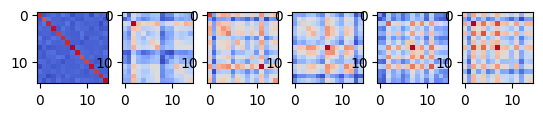

dict_keys(['qk_layer', 'v_layer', '__call__'])
q shape:(15, 4, 64, 32)
q mean: 0.42
0.005502549
(64, 64)
dict_keys(['qk_layer', 'v_layer', '__call__'])
q shape:(15, 4, 64, 32)
q mean: 0.44
0.005482058
(64, 64)
dict_keys(['qk_layer', 'v_layer', '__call__'])
q shape:(15, 4, 64, 32)
q mean: 0.44
0.00598872
(64, 64)
dict_keys(['qk_layer', 'v_layer', '__call__'])
q shape:(15, 4, 64, 32)
q mean: 0.46
0.007095895
(64, 64)
dict_keys(['qk_layer', 'v_layer', '__call__'])
q shape:(15, 4, 64, 32)
q mean: 0.48
0.007528662
(64, 64)


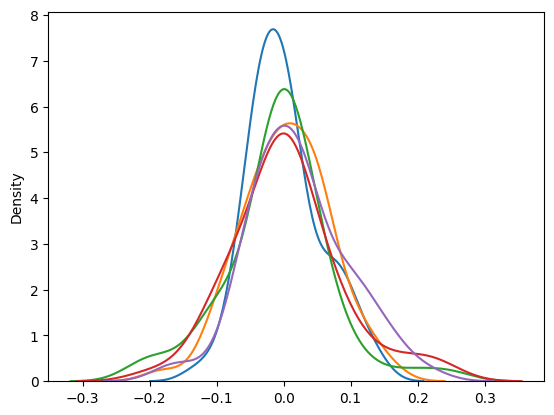

In [13]:
print(state['intermediates'].keys())

count = 0
for k in state['intermediates'].keys():
    if "Dense" in k:
        print(k)
        h = state['intermediates'][k]['__call__'][0]      
        print("h mean %0.2f" % jnp.mean(h**2))
        if len(h.shape) == 3:
            H = jnp.einsum('ijk,ljk->il', h, h) / ( h.shape[1] * h.shape[2] )
            plt.subplot(1, depth+1, count + 1)
            plt.imshow(H, cmap = 'coolwarm')
        count += 1
plt.show()

plt.figure()
count = 0
for k in state['intermediates'].keys():
    if "Attention" in k:
        print(state['intermediates'][k].keys())
        qk = state['intermediates'][k]['qk_layer']['__call__'][0] /  heads**(0.5) /  dim**(0.5)
        qk = rearrange( qk, 'b l (h d) -> b h l d' , h = heads) # (batch, heads, loc, d )
        q,k = jnp.split( qk, 2, axis = -1 ) # gives q, k each of shape ( batch, heads, loc, d )
        print("q shape:" + str(q.shape))
        print("q mean: %0.2f" % jnp.mean(q**2))
        A = 1.0 / dim * jnp.einsum('ijkl,ijml->ijkm', q, k) # batch x heads x loc x loc
        print(jnp.mean(A**2))
        #plt.subplot(2, depth + 1, count + 1)
        print(A[0,0].shape)
        #plt.imshow(A[0,0],cmap = 'coolwarm')
        count += 1
        sns.kdeplot(A[:,:,20,20].flatten())
plt.show()

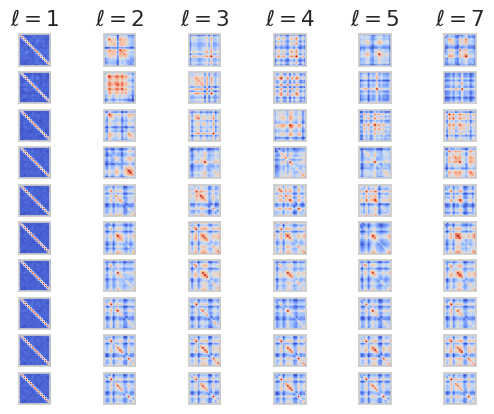

'\nheads = 4\ndims = [32,64,128,256,512,1024]\ncount = 0\nall_H_vary_N = []\nplt.figure()\nfor i, dim in enumerate(dims):\n    model = simple_TF(dim = dim, heads = heads, depth = depth, patch_size = patch_size, scale_exp = 1.0, adam_scale = 0.0)\n    Hi = []\n    for j in range(num_inits):\n        params = model.init(random.PRNGKey(j), jnp.ones((4,32,32,3)) ) \n        out, state = model.apply(params, x, capture_intermediates=True, mutable=["intermediates"])\n        Hij = []\n        for k in state[\'intermediates\'].keys():\n            if "Dense" in k and "0" not in k:\n                h = state[\'intermediates\'][k][\'__call__\'][0] / jnp.sqrt(dim*heads)        \n                if len(h.shape) == 3:\n                    H = jnp.einsum(\'ijk,ljk->il\', h, h) / ( h.shape[1] * h.shape[2] )\n                    plt.subplot(len(head_vals), depth+1, count + 1)\n                    plt.imshow(H, cmap = \'coolwarm\')\n                    plt.xticks([])\n                    plt.yticks([])

In [47]:
dim = 4
head_vals = [8,16,32,64,128,256,512,1024,2048,2049]
all_H = []

num_inits = 64

plt.figure()
count = 0
for i, heads in enumerate(head_vals):
    model = simple_TF(dim = dim, heads = heads, depth = depth, patch_size = patch_size, scale_exp = 1.0, adam_scale = 0.0)
    
    Hi = []
    for j in range(num_inits):
        params = model.init(random.PRNGKey(j), jnp.ones((4,32,32,3)) ) 
        out, state = model.apply(params, x, capture_intermediates=True, mutable=["intermediates"])
        Hij = []
        layer = 0
        for k in state['intermediates'].keys():
            if "Dense" in k:
                layer += 1
                h = state['intermediates'][k]['__call__'][0] / jnp.sqrt(dim*heads)   
                h = nn.gelu(h)
                if len(h.shape) == 3:
                    H = jnp.einsum('ijk,ljk->il', h, h) / ( h.shape[1] * h.shape[2] )
                    if j == 0:
                        plt.subplot(len(head_vals), depth+1, count + 1)
                        plt.imshow(H, cmap = 'coolwarm')
                        plt.xticks([])
                        plt.yticks([])
                        count += 1

                    Hij += [H]
                    
                if j==0 and count == 0:
                    plt.ylabel(r'$\mathcal{H} = %d$' % heads)
                if i == 0:
                    plt.title(r'$\ell = %d$' % layer)
        Hi += [Hij]
        
    all_H += [ Hi ]
plt.show()

"""
heads = 4
dims = [32,64,128,256,512,1024]
count = 0
all_H_vary_N = []
plt.figure()
for i, dim in enumerate(dims):
    model = simple_TF(dim = dim, heads = heads, depth = depth, patch_size = patch_size, scale_exp = 1.0, adam_scale = 0.0)
    Hi = []
    for j in range(num_inits):
        params = model.init(random.PRNGKey(j), jnp.ones((4,32,32,3)) ) 
        out, state = model.apply(params, x, capture_intermediates=True, mutable=["intermediates"])
        Hij = []
        for k in state['intermediates'].keys():
            if "Dense" in k and "0" not in k:
                h = state['intermediates'][k]['__call__'][0] / jnp.sqrt(dim*heads)        
                if len(h.shape) == 3:
                    H = jnp.einsum('ijk,ljk->il', h, h) / ( h.shape[1] * h.shape[2] )
                    plt.subplot(len(head_vals), depth+1, count + 1)
                    plt.imshow(H, cmap = 'coolwarm')
                    plt.xticks([])
                    plt.yticks([])
                    count += 1
                
                    Hij += [H]
        Hi += [Hij]
    all_H_vary_N += [Hi]
plt.show()
"""

(10, 64, 6, 15, 15)
(6, 10)


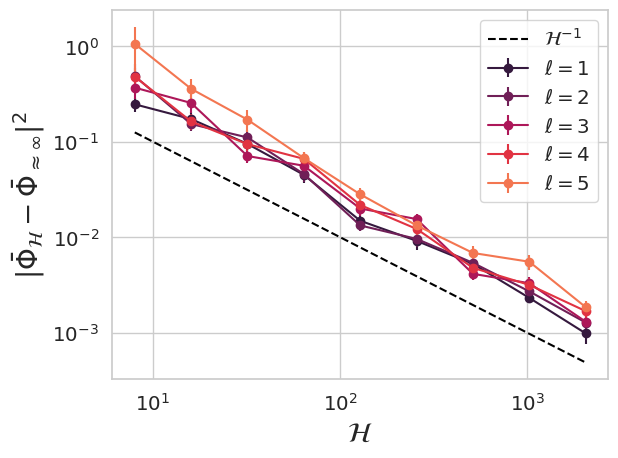

In [48]:
all_H = jnp.array(all_H)
print(all_H.shape) # head_vals x inits x layers x samples x samples

errs = jnp.mean( ( all_H - all_H[-1,:,:,:,:].mean(axis=0)[jnp.newaxis,jnp.newaxis,:,:,:] )**2 , axis = (1,-2,-1)) / jnp.mean( (all_H[-1,:,:,:,:].mean(axis=0)[jnp.newaxis,jnp.newaxis,:,:,:] )**2 , axis = (1,-2,-1))

std_devs = jnp.std( jnp.mean( ( all_H - all_H[-1,:,:,:,:].mean(axis=0)[jnp.newaxis,jnp.newaxis,:,:,:] )**2 , axis = (-2,-1)) / jnp.mean( (all_H[-1,:,:,:,:].mean(axis=0)[jnp.newaxis,jnp.newaxis,:,:,:] )**2 , axis = (1,-2,-1)),  axis =1)

errs = errs.T
std_devs = std_devs.T

print(errs.shape)

sns.set(font_scale=1.3)
sns.set_style("whitegrid")
sns.set_palette("rocket", n_colors=len(errs))

for i, err in enumerate(errs[1:]):
    plt.errorbar( head_vals[:-1], err[:-1], std_devs[i+1,:-1] / jnp.sqrt( num_inits ), fmt = '-o', label = r'$\ell = %d$' % (i+1))

plt.plot(head_vals[:-1], jnp.array(head_vals[:-1], dtype = jnp.float32)**(-1.0), '--', color = 'black', label = r'$\mathcal{H}^{-1}$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$\mathcal{H}$',fontsize = 20)
plt.ylabel(r'$|\bar{\Phi}_{\mathcal{H}}  - \bar{\Phi}_{\approx \infty} |^2$',fontsize = 20)
plt.savefig('figures/bar_phi_init_convg.pdf',bbox_inches = 'tight')
plt.show()


In [104]:
# make plot of attention distribution across different values of H

dim = 16
head_vals = [32,64,128,256]
all_A = []

num_inits = 32

plt.figure()
count = 0
for i, heads in enumerate(head_vals):
    model = simple_TF(dim = dim, heads = heads, depth = depth, patch_size = patch_size, scale_exp = 1.0, adam_scale = 0.0)
    
    Ai = []
    for j in range(num_inits):
        params = model.init(random.PRNGKey(j), jnp.ones((4,32,32,3)) ) 
        out, state = model.apply(params, x, capture_intermediates=True, mutable=["intermediates"])
        Aij = []
        layer = 0
        for k in state['intermediates'].keys():
            if "Attention" in k:
                qk = state['intermediates'][k]['qk_layer']['__call__'][0] /  heads**(0.5) /  dim**(0.5)
                qk = rearrange( qk, 'b l (h d) -> b h l d' , h = heads) # (batch, heads, loc, d )
                q,k = jnp.split( qk, 2, axis = -1 ) # gives q, k each of shape ( batch, heads, loc, d )
                A = 1.0 / dim**(1.0) * jnp.einsum('ijkl,ijml->ijkm', q, k) # batch x heads x loc x loc
                Aij += [ A[0,:,4,4] ]
        Ai += [Aij]
    all_A += [Ai]
plt.show()


<Figure size 640x480 with 0 Axes>

(32, 5, 32)
(32, 5, 64)
(32, 5, 128)
(32, 5, 256)


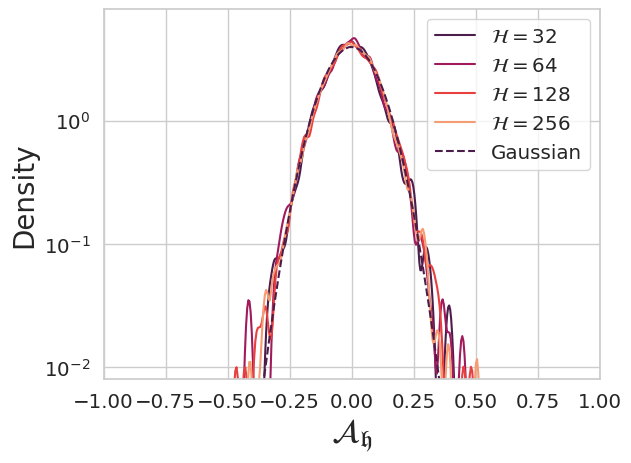

In [105]:
plt.figure()
sns.set_palette("rocket", n_colors=len(all_A))
for i, Ai in enumerate(all_A):
    Ai = jnp.array(Ai)
    print(Ai.shape)
    Ai = Ai[:,-1,:]
    sns.kdeplot(Ai.flatten(), bw_adjust = 0.5, label = r'$\mathcal{H} = %d$' % head_vals[i])
sigma = Ai.flatten().std()
xs = jnp.linspace(-1.0,1.0,100)
Gauss = jnp.exp(-0.5 * xs**2 / sigma**2 ) / jnp.sqrt(2*jnp.pi*sigma**2)
plt.plot( xs, Gauss , '--', label = 'Gaussian')
plt.xlabel(r'$\mathcal{A}_{\mathfrak{h}}$',fontsize = 24)
plt.ylabel(r'Density', fontsize = 20)
plt.yscale('log')
plt.ylim([8e-3,8.0])
plt.xlim([-1.0,1.0])
plt.legend()
#plt.title(f'$N = {dim}$', fontsize = 20)
plt.savefig(f'figures/attn_entries_last_init_converge_N_{dim}.pdf',bbox_inches = 'tight')
plt.show()


In [3]:
data_dir = '/n/holyscratch01/pehlevan_lab/Everyone/cifar-5m-new'
file_name = f"{data_dir}/cifar5m_part{0}.npz"
part0 = np.load(file_name, allow_pickle=True)
X0, y0 = np.load(file_name, allow_pickle=True)

arr = [part0[k] for k in part0.keys()]
X = arr[0]
y = arr[1]
mean = X.mean()
std = X.std()
X = (X - mean) / std
print(y.shape)
print(X.shape)
print(X.dtype)

(1000448,)
(1000448, 32, 32, 3)
float64


(4, 4, 8, 8, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

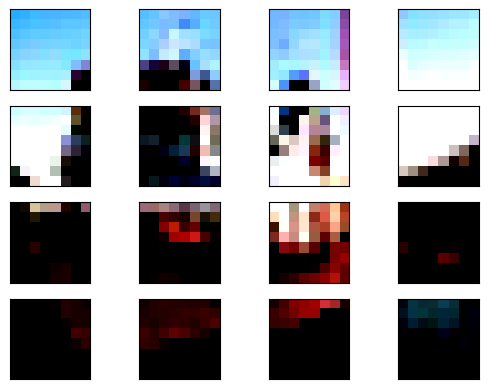

In [22]:
x_re = rearrange(X[0], '(a p1) (b p2) c -> a b p1 p2 c', p1 = 8, p2 = 8)
print(x_re.shape)

plt.figure()
for a in range(4):
    for b in range(4):
        plt.subplot(4,4,4*a+b+1)
        plt.imshow(x_re[a,b,:,:,:])
        plt.xticks([])
        plt.yticks([])
plt.show()

## Train VIT on CIFAR-5M

In [4]:
def get_data(dset_count):
    
    data_dir = '/n/holyscratch01/pehlevan_lab/Everyone/cifar-5m-new'
    file_name = f"{data_dir}/cifar5m_part{dset_count}.npz"
    part0 = np.load(file_name, allow_pickle=True)

    arr = [part0[k] for k in part0.keys()]
    X = arr[0]
    y = arr[1]
    mean = X.mean()
    std = X.std()
    X = (X - mean) / std
    return X, y

def train_model(param_args, opt_args, data = None, adam = False, seed = 0):

    dim, heads, depth, patch_size, scale_exp, beta = param_args
    T, batch, gamma, lr = opt_args
    
    if adam:
        adam_scale = 1.0
        opt_init, opt_update, get_params = optimizers.adam( lr / jnp.sqrt(heads * dim) , eps = 1e-20)

    else:
        adam_scale = 0.0
        opt_init, opt_update, get_params = optimizers.sgd( depth * heads * dim * gamma**2 *  lr)

    #model = VIT(dim = dim, heads = heads, depth = depth, patch_size = patch_size, scale_exp = scale_exp, adam_scale = adam_scale)
    model = simple_TF(dim = dim, heads = heads, depth = depth, patch_size = patch_size, scale_exp = scale_exp, adam_scale = adam_scale, beta = beta)
    params = model.init(random.PRNGKey(seed), jnp.ones((4,32,32,3)) )['params']
                                                               
    opt_state = opt_init(params)

    shift_fn = jax.jit(lambda p, x: (model.apply({'params':p}, x) - model.apply({'params':params}, x)) / gamma)
    #shift_fn = jax.jit(lambda p, x: model.apply({'params':p}, x) / gamma)
    loss_fn = jax.jit(lambda params, Xb, yb: optax.softmax_cross_entropy_with_integer_labels(logits=shift_fn(params, Xb), labels=yb).mean())
    grad_fn = jax.jit(jax.grad(loss_fn))


    losses = []
    
    loss_t = 0.0
    dset_count = 0
    
    if data != None:
        X,y = data
    
    comp_every = 10
    loss_t = 0.0
    for t in range(T):
    
        if data == None:
            if t == 0:
                X, y = get_data(dset_count)
                ind = 0
            elif ind+batch >= X.shape[0]:
            
                if dset_count < 4:
                    dset_count += 1
                    X, y = get_data(dset_count)
                    ind = 0
                else:
                    return losses
        else:
            ind = (t*batch) % X.shape[0]
        Xt = X[ind:ind+batch]
        yt = y[ind:ind+batch]
        ind += batch
        
        if t % comp_every == 0 and t > 0:
            losses += [loss_t]
            sys.stdout.write(f'\r loss = {loss_t}')
            loss_t = 0.0

        loss_t += 1/comp_every * loss_fn(get_params(opt_state), Xt, yt)
        #loss_t = loss_t * t/(t+1) + 1.0/(t+1) * loss_fn(get_params(opt_state), Xt, yt)
        #loss_t = loss_fn(get_params(opt_state), Xt, yt)
        
        opt_state = opt_update(t, grad_fn(get_params(opt_state), Xt, yt),opt_state)
        
    preds = shift_fn(get_params(opt_state), Xt)
    return losses, preds


def get_run_name(args):
    return "VIT/early_cifar/lr_{:.4f}/batch_size_{}/steps_{}/width_{}/heads_{}/depth_{}/scale_exp_{}/beta_{}/gamma_zero_{}".format(args.lr, args.batch_size, args.steps, args.width, args.heads, args.depth, args.scale_exp, args.beta, args.gamma_zero)

### Convergence Experiments

Things to show

1. Predictions $f$ converge as $H \to \infty$
2. Distribution over attention $A$ converges

(10, 249)
(10, 249)
(10, 249)
(10, 249)
(10, 249)
(10, 249)
(10, 249)


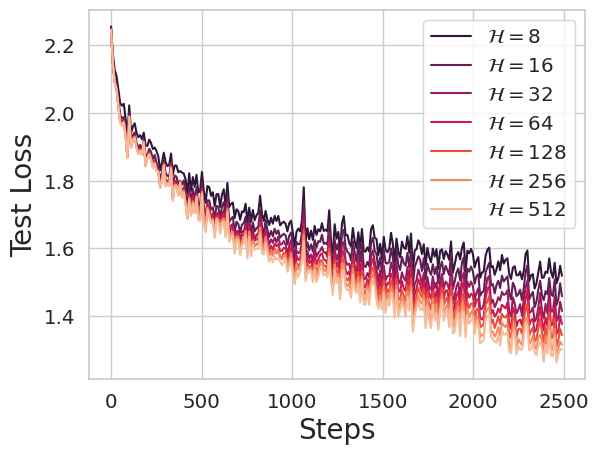

(10, 249)
(10, 249)
(10, 249)
(10, 249)
(10, 249)
(10, 249)


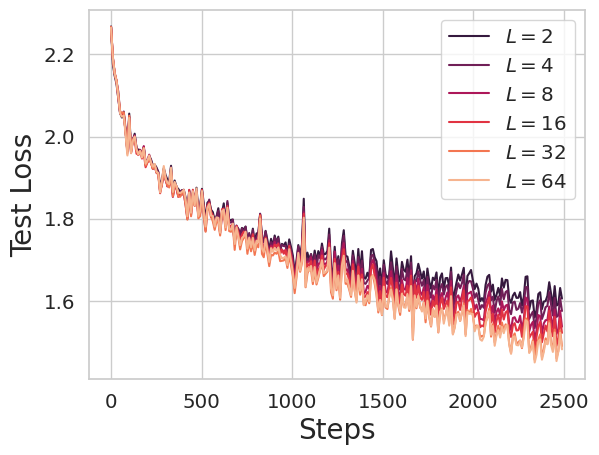

(10, 249)
(10, 249)
(10, 249)
(10, 249)
(10, 249)
(10, 249)
(10, 249)


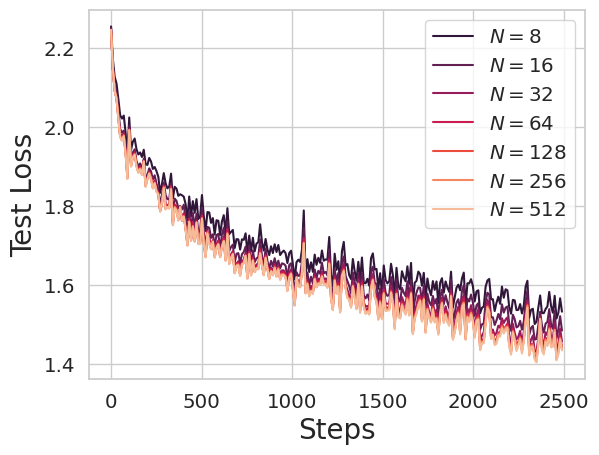

(10, 249)
(10, 249)
(10, 249)
(10, 249)
(10, 249)
(10, 249)
(10, 249)


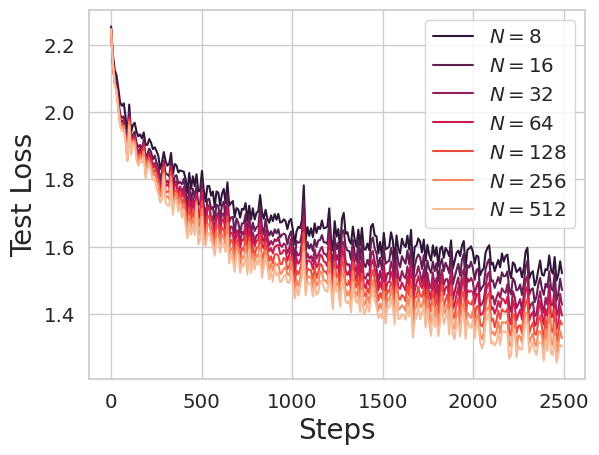

In [169]:
import argparse
import os
def get_run_name(args):
    return "VIT/early_cifar/lr_{:.4f}/batch_size_{}/steps_{}/width_{}/heads_{}/depth_{}/scale_exp_{}/beta_{}/gamma_zero_{}".format(args.lr, args.batch_size, args.steps, args.width, args.heads, args.depth, args.scale_exp, args.beta, args.gamma_zero)


class Args(argparse.Namespace):
    lr = 1.0
    steps = 2500
    batch_size = 128
    scale_exp = 1.0
    depth = 2
    width = 4
    beta = 4.0
    gamma_zero = 0.2
    heads = 32
    

args = Args()
save_dir = '/n/holyscratch01/pehlevan_lab/Users/bbordelon/bbordelon/Learn_gates/early_conv'


sns.set(font_scale=1.3)
sns.set_style("whitegrid")
sns.set_palette("rocket", n_colors=7)

"""
widths = [8, 16, 32, 64]
for i, width in enumerate(widths):
    args.width = width
    run_name = get_run_name(args)
    save_path = os.path.join(save_dir, run_name.replace("/", "-") + '-losses.npy')

    losses =np.load(save_path)
    print(losses.shape)
    plt.plot(losses.mean(axis=0))
plt.show()
"""

args.width = 4
head_vals = [8, 16, 32, 64, 128, 256, 512]
for i, heads in enumerate(head_vals):
    args.heads = heads
    run_name = get_run_name(args)
    save_path = os.path.join(save_dir, run_name.replace("/", "-") + '-losses.npy')

    losses =np.load(save_path)
    print(losses.shape)
    plt.plot(np.linspace(0,10 * losses.shape[1],losses.shape[1]), losses.mean(axis=0), label = r'$\mathcal{H} = %d$' % heads)
plt.legend()
plt.xlabel(r'Steps',fontsize =20)
plt.ylabel(r'Test Loss',fontsize = 20)
plt.savefig(f'figures/early_conv_vary_H_N_{args.width}_L_{args.depth}.pdf',bbox_inches='tight')
plt.show()




args.width = 4
args.heads = 4
depths = [2, 4, 8, 16, 32, 64]
sns.set_palette("rocket", n_colors=len(depths))

for i, depth in enumerate(depths):
    args.depth = depth
    run_name = get_run_name(args)
    save_path = os.path.join(save_dir, run_name.replace("/", "-") + '-losses.npy')
    losses =np.load(save_path)
    print(losses.shape)
    plt.plot(np.linspace(0,10 * losses.shape[1],losses.shape[1]),losses.mean(axis=0), label = r'$L = %d$' % depth)
plt.legend()
plt.xlabel(r'Steps',fontsize =20)
plt.ylabel(r'Test Loss',fontsize = 20)
plt.savefig(f'figures/early_conv_vary_L_N_{args.width}_H_{args.heads}.pdf',bbox_inches='tight')
plt.show()

"""
args.scale_exp = 0.5
widths = [8, 16, 32, 64]
args.depth = 2
args.heads = 32
for i, width in enumerate(widths):
    args.width = width
    run_name = get_run_name(args)
    save_path = os.path.join(save_dir, run_name.replace("/", "-") + '-losses.npy')
    losses = np.load(save_path)
    print(losses.shape)
    plt.plot(losses.mean(axis=0))
plt.show()
"""


args.scale_exp = 1.0
widths = [8, 16, 32, 64, 128, 256, 512]
sns.set_palette("rocket", n_colors=len(widths))

args.depth = 2
args.heads = 4
for i, width in enumerate(widths):
    args.width = width
    run_name = get_run_name(args)
    save_path = os.path.join(save_dir, run_name.replace("/", "-") + '-losses.npy')

    losses =np.load(save_path)
    print(losses.shape)
    plt.plot(np.linspace(0,10 * losses.shape[1],losses.shape[1]),losses.mean(axis=0), label = r'$N = %d$' % args.width)

plt.legend()
plt.xlabel(r'Steps',fontsize =20)
plt.ylabel(r'Test Loss',fontsize = 20)
plt.savefig(f'figures/early_conv_vary_N_scale_exp_{args.scale_exp}_H_{args.heads}_L_{args.depth}.pdf',bbox_inches='tight')
plt.show()


args.scale_exp = 0.5
widths = [8, 16, 32, 64, 128, 256, 512]
args.depth = 2
args.heads = 4
for i, width in enumerate(widths):
    args.width = width
    run_name = get_run_name(args)
    save_path = os.path.join(save_dir, run_name.replace("/", "-") + '-losses.npy')

    losses =np.load(save_path)
    print(losses.shape)
    plt.plot(np.linspace(0,10 * losses.shape[1],losses.shape[1]),losses.mean(axis=0), label = r'$N = %d$' % args.width)
plt.legend()
plt.xlabel(r'Steps',fontsize =20)
plt.ylabel(r'Test Loss',fontsize = 20)
plt.savefig(f'figures/early_conv_vary_N_scale_exp_{args.scale_exp}_H_{args.heads}_L_{args.depth}.pdf',bbox_inches='tight')
plt.show()

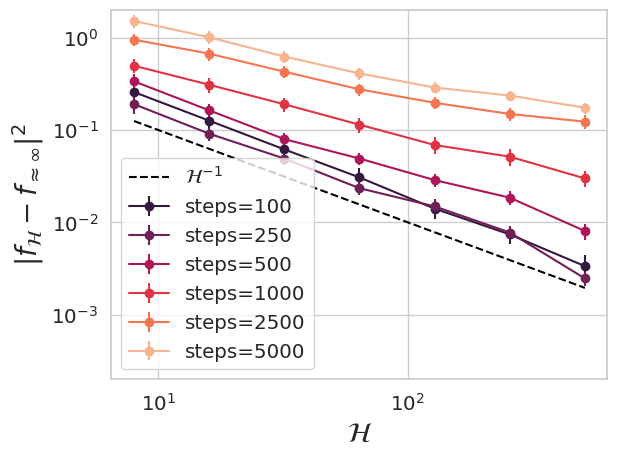

In [185]:
# vary the number of steps, ... 

args.width = 4
head_vals = [8, 16, 32, 64, 128, 256, 512]
step_vals = [100,250, 500,1000, 2500,5000]

sns.set_palette("rocket", n_colors=len(step_vals))

for i, steps in enumerate(step_vals):
    args.scale_exp = 1.0
    args.steps = steps
    args.heads = 512
    run_name = get_run_name(args)
    
    save_path = os.path.join(save_dir, run_name.replace("/", "-") + '-preds.npy')
    preds_inf = np.load(save_path)

    errs = []
    stds = []
    for j, heads in enumerate(head_vals):
        args.heads = heads
        run_name = get_run_name(args)
        save_path = os.path.join(save_dir, run_name.replace("/", "-") + '-preds.npy')

        preds = np.load(save_path)
        errs += [jnp.mean(( preds - preds_inf.mean(axis=0)[jnp.newaxis,:] )**2 )]
        stds += [ jnp.std( jnp.mean(( preds - preds_inf.mean(axis=0)[jnp.newaxis,:] )**2, axis = 1) )  ] 
    plt.errorbar(head_vals, errs, jnp.array(stds)/jnp.sqrt(10), fmt='-o', label = f'steps={steps}')
plt.loglog(head_vals,  jnp.array(head_vals)**(-1.0), '--', color = 'black', label = r'$\mathcal{H}^{-1}$')
plt.legend()
plt.ylim([2e-4,2.0])
plt.xlabel(r'$\mathcal{H}$',fontsize = 20)
plt.ylabel(r'$|f_{\mathcal{H}} - f_{\approx \infty}|^2$',fontsize = 20)
plt.savefig(f'figures/early_conv_logit_vary_H_N_{args.width}_L_{args.depth}.pdf',bbox_inches='tight')
plt.show()

## $N$ scaling with $\beta = 1$

In [5]:
dimvals = [8, 16, 32]
depth = 2
heads = 64
patch_size = 4
scale_exp = 1.0
beta = 4.0

T = 2500
lr = 1.0
gamma = 0.2
batch = 128

num_inits = 5

opt_args = ( T, batch, gamma, lr )

all_losses = []
all_preds = []
for i, dim in enumerate(dimvals):
    print(" ")
    print(f"dim = {dim}")
    all_losses_i = []
    all_preds_i = []
    for j in range(num_inits):
        param_args = (dim, heads, depth, patch_size, scale_exp, beta)    
        losses, preds = train_model(param_args, opt_args, data = (X,y), seed = j)
        all_losses_i += [losses] 
        all_preds_i += [preds]
    all_losses += [all_losses_i]
    all_preds += [all_preds_i]

 
dim = 8
 loss = 1.3743625879287721

KeyboardInterrupt: 

In [ ]:
import os
all_losses = jnp.array(all_losses)
all_preds = jnp.array(all_preds)

save_dir = '/n/holyscratch01/pehlevan_lab/Users/bbordelon/bbordelon/Learn_gates/early_conv'

save_path = os.path.join(save_dir, f"VIT_early_losses_H_{heads}_scale_exp_{1}_vary_N.npy")
np.save(save_path, all_losses)
save_path = os.path.join(save_dir, f"VIT_early_preds_H_{heads}_scale_exp_{1}_vary_N.npy")
np.save(save_path, all_preds)

In [ ]:
save_dir = '/n/holyscratch01/pehlevan_lab/Users/bbordelon/bbordelon/Learn_gates/early_conv'
save_path = os.path.join(save_dir, f"VIT_early_losses_H_{heads}_scale_exp_{1}_vary_N.npy")
losses_plot = np.load(save_path)
save_path = os.path.join(save_dir, f"VIT_early_preds_H_{heads}_scale_exp_{1}_vary_N.npy")
preds_plot = np.load(save_path)

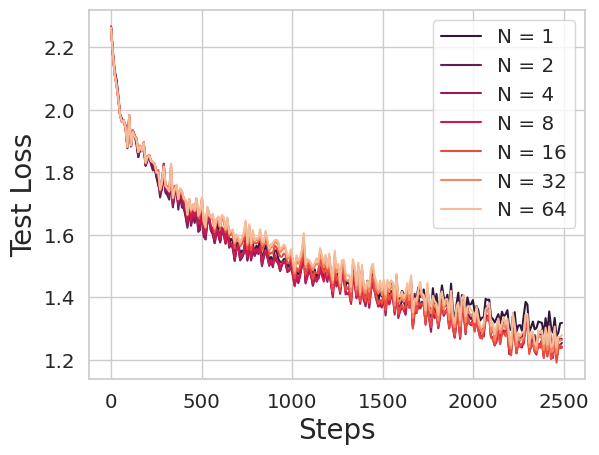

(5, 128, 10)
(5, 128, 10)
(5, 128, 10)
(5, 128, 10)
(5, 128, 10)
(5, 128, 10)
(5, 128, 10)


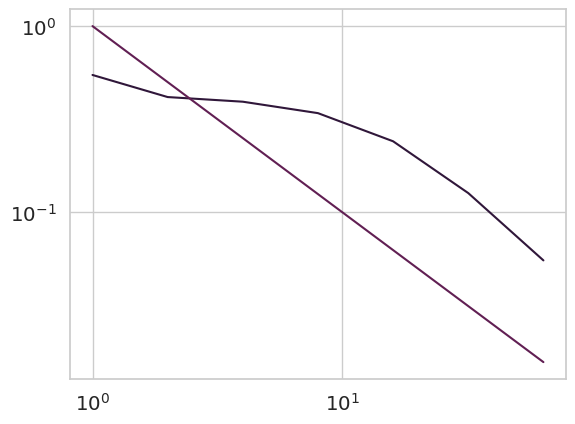

In [28]:
sns.set(font_scale=1.3)
sns.set_style("whitegrid")
sns.set_palette("rocket", n_colors=len(dimvals))

for i, loss_i in enumerate(losses_plot[:-1]):
    loss = loss_i.mean(axis=0)
    plt.plot(np.linspace(0,len(loss)*10,len(loss)),loss, label = f'N = {dimvals[i]}')
plt.legend()
plt.xlabel(r'Steps', fontsize = 20)
plt.ylabel(r'Test Loss',fontsize = 20)
#plt.title(r'Vary $N$',fontsize = 16)
plt.savefig(f'figures/training_cf5m_H_{heads}_vary_N.pdf',bbox_inches='tight')
plt.show()
 
diffs = []
for i, preds_i in enumerate(preds_plot[:-1]):
    
    print(preds_i.shape) # inits x batch x outputs
    diff = jnp.mean( (preds_i - preds_plot[-1].mean(axis=0)[jnp.newaxis,:,:] )**2 )
    diffs += [diff]
    
plt.loglog(dimvals, diffs)
plt.loglog(dimvals, jnp.array(dimvals)**(-1.0))
plt.show()

## $N$ scaling with $\beta = 1/2$ 

In [ ]:
dimvals = [8, 16, 32,64, 128, 256, 512, 513]
depth = 2
heads = 64
patch_size = 4
scale_exp = 0.5
beta = 4.0

T = 2500
lr = 0.8
gamma = 0.2
batch = 128

num_inits = 5

opt_args = ( T, batch, gamma, lr )

all_losses = []
all_preds = []
for i, dim in enumerate(dimvals):
    print(" ")
    print(f"dim = {dim}")
    all_losses_i = []
    all_preds_i = []
    for j in range(num_inits):
        param_args = (dim, heads, depth, patch_size, scale_exp, beta)    
        losses, preds = train_model(param_args, opt_args, data = (X,y), seed = j)
        all_losses_i += [losses] 
        all_preds_i += [preds]
    all_losses += [all_losses_i]
    all_preds += [all_preds_i]

In [16]:
dim = 4
depth = 4
head_vals = [16, 32, 64, 128, 256, 512]
patch_size = 4
scale_exp = 1.0

T = 5000
lr = 0.5
gamma = 0.25
batch = 64

opt_args = ( T, batch, gamma, lr )

all_losses = []
for i, heads in enumerate(head_vals):
    
    param_args = (dim, heads, depth, patch_size, scale_exp)
    print(" ")
    print(f"H = {heads}")
    losses = train_model(param_args, opt_args, data = None)
    all_losses += [losses] 

 
H = 16
 loss = 1.5409995317459106 
H = 32
 loss = 1.4948648214340218 
H = 64
 loss = 1.4633910655975342 
H = 128
 loss = 1.4563044309616089 
H = 256
 loss = 1.4367902278900146 
H = 512
 loss = 1.4191836118698128

ValueError: Input could not be cast to an at-least-1D NumPy array

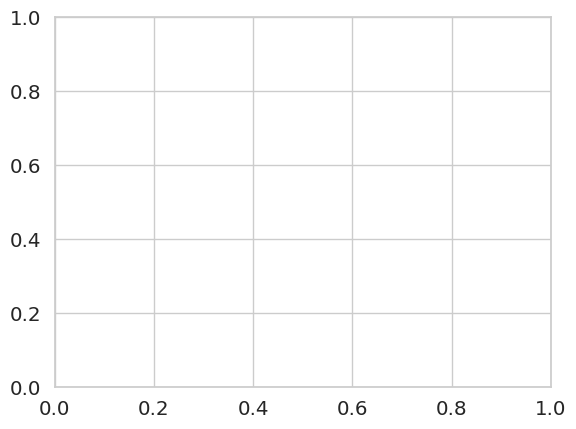

In [17]:
sns.set(font_scale=1.3)
sns.set_style("whitegrid")
sns.set_palette("rocket", n_colors=len(dimvals))

for i, loss in enumerate(all_losses):
    plt.plot(loss, label = r'$\mathcal{H} = %d$' % head_vals[i])
plt.xlabel(r'Steps', fontsize = 20)
plt.ylabel(r'Test Loss',fontsize = 20)
#plt.title(r'Vary $N$',fontsize = 16)
plt.legend()

plt.savefig('figures/training_cf5m_vary_H.pdf',bbox_inches='tight')
plt.show()

In [84]:
depths = [2,4,8,16,32]
dim = 8
depth = 2
heads = 16
patch_size = 4
scale_exp = 1.0

T = 2000
lr = 0.01
gamma = 0.5
batch = 256

opt_args = ( T, batch, gamma, lr )

all_losses = []
for i, depth in enumerate(depths):
    param_args = (dim, heads, depth, patch_size, scale_exp)
    print(" ")
    print(f"L = {depth}")
    losses = train_model(param_args, opt_args, (X, y))
    all_losses += [losses] 

 
L = 2
 loss = 1.5068228244781494 
L = 4
 loss = 1.5097254514694214 
L = 8
 loss = 1.5188524723052979 
L = 16
 loss = 1.5124251842498784 
L = 32
 loss = 1.5298936367034912

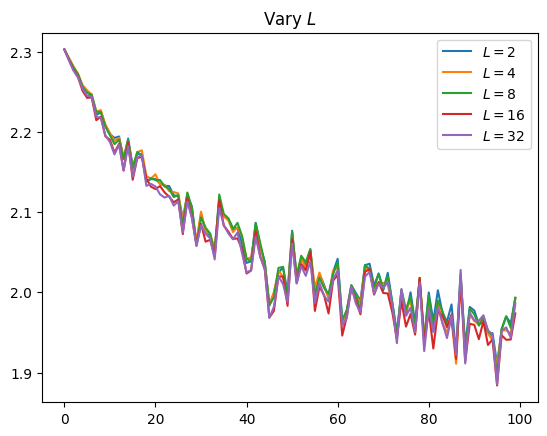

In [87]:
for i, loss in enumerate(all_losses):
    plt.plot(loss[0:100], label = r'$L = %d$' % depths[i])
plt.legend()
plt.title(r'Vary $L$')
plt.show()

In [61]:
dimvals = [4, 8, 16, 32, 64]
depth = 2
heads = 3
patch_size = 4
scale_exp = 0.5

T = 1000

lr = 0.1
gamma = 0.75
batch = 64

opt_args = ( T, batch, gamma, lr )

all_losses = []
for i, dim in enumerate(dimvals):
    param_args = (dim, heads, depth, patch_size, scale_exp)
    print(" ")
    print(f"dim = {dim}")
    losses = train_model(param_args, opt_args)
    all_losses += [losses] 

 
dim = 4
 loss = 1.9258025884628296 
dim = 8
 loss = 1.8374379873275757 
dim = 16
 loss = 1.8021626472473145 
dim = 32
 loss = 1.7546936273574836 
dim = 64
 loss = 1.7541667222976685

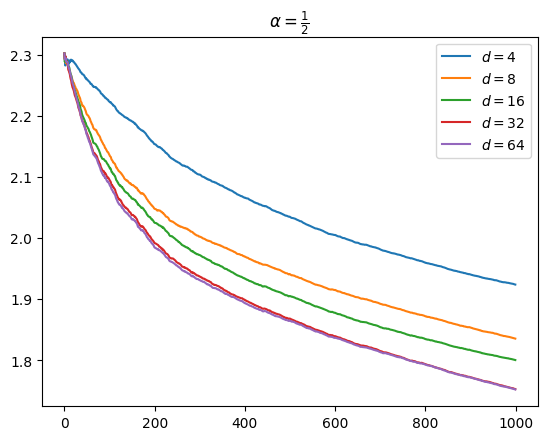

In [63]:
for i, loss in enumerate(all_losses):
    plt.plot(loss, label = r'$d = %d$' % dimvals[i])
plt.legend()
plt.title(r'$\alpha = \frac{1}{2}$')
plt.show()

## LR Transfer

In [12]:
dimvals = [4, 8, 16, 32]
depth = 6
heads = 4
patch_size = 4
scale_exp = 1.0

T = 1000
gamma = 1.0
batch = 128

lrs = jnp.logspace(-1.5, 0.6, 6)

all_losses = []
for i, dim in enumerate(dimvals):
    param_args = (dim, heads, depth, patch_size, scale_exp)
    print(" ")
    print(f"dim = {dim}")
    
    losses_i = []
    for j, lr in enumerate(lrs):
        opt_args = ( T, batch, gamma, lr )
        losses_i += [train_model(param_args, opt_args, (X, y))]        
    all_losses += [losses_i] 
    
    

 
dim = 4
 loss = nan893662452697754 
dim = 8
 loss = nan .1303710937555
dim = 16
 loss = nan3.6650390625873 
dim = 32
 loss = nan739264011383057

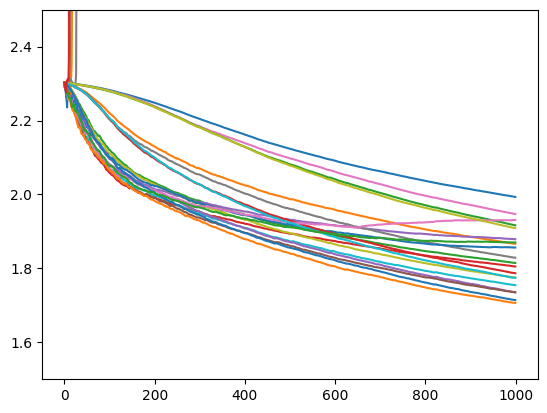

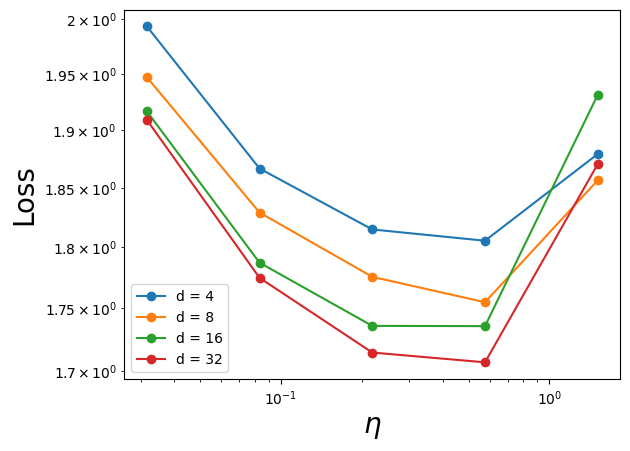

In [13]:
final_losses = []
for loss in all_losses:
    final_i = []
    for loss_eta in loss:
        plt.plot(loss_eta)
        final_i += [loss_eta[-1]]
    final_losses += [final_i]
plt.ylim([1.5,2.5])
plt.show()


for i,loss in enumerate(final_losses):
    plt.loglog(lrs, loss, '-o', label = f'd = {dimvals[i]}')
plt.legend()
plt.xlabel(r'$\eta$',fontsize = 20)
plt.ylabel(r'Loss', fontsize = 20)
plt.show()

In [14]:
dimvals = [4, 8, 16, 32]
depth = 6
heads = 4
patch_size = 4
scale_exp = 0.5

T = 1000
gamma = 1.0
batch = 128

lrs = jnp.logspace(-1.5, 0.6, 6)

all_losses_half = []
for i, dim in enumerate(dimvals):
    param_args = (dim, heads, depth, patch_size, scale_exp)
    print(" ")
    print(f"dim = {dim}")
    
    losses_i = []
    for j, lr in enumerate(lrs):
        opt_args = ( T, batch, gamma, lr )
        losses_i += [train_model(param_args, opt_args, (X, y))]        
    all_losses_half += [losses_i] 
    
    

 
dim = 4
 loss = nan865818023681644 
dim = 8
 loss = nan5.5703125066406 
dim = 16
 loss = nan2669056.0146973 
dim = 32
 loss = nan934746742248535

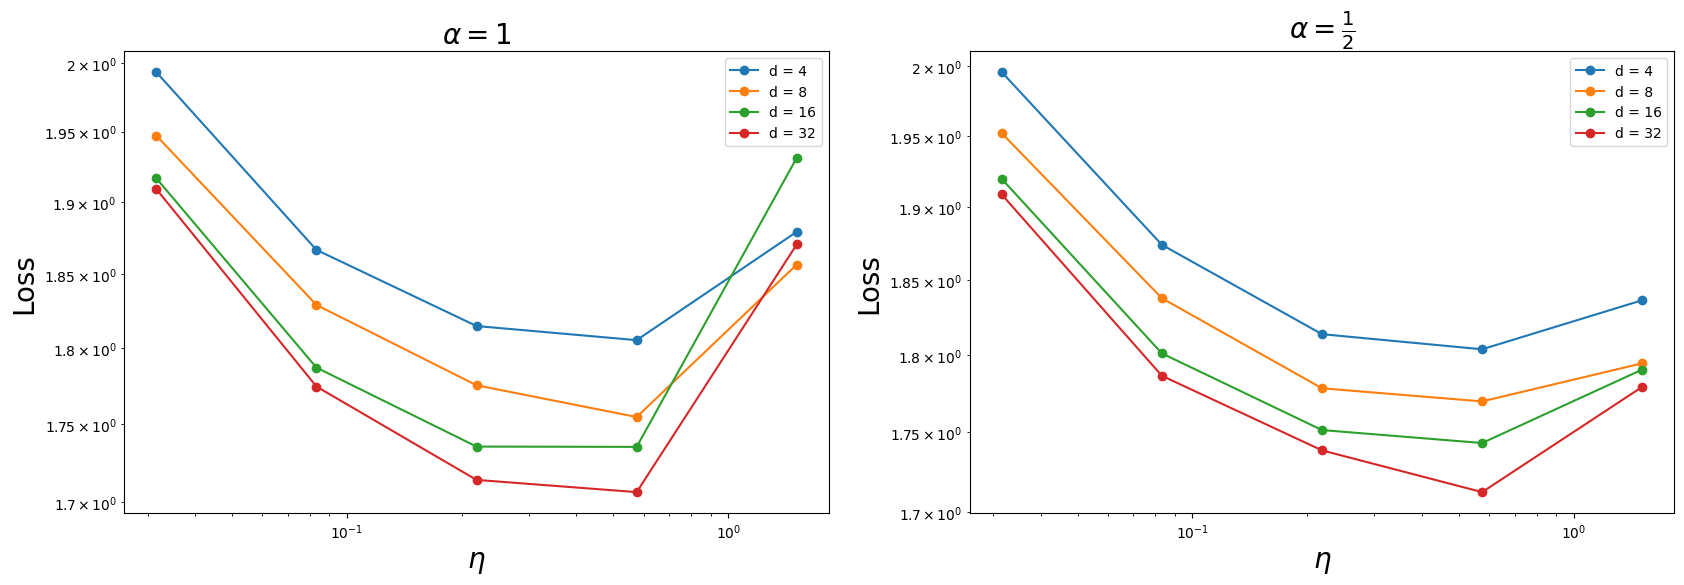

In [23]:
final_half= []
for i,loss in enumerate(all_losses_half):
    final_i = []
    for loss_eta in loss:
         
        final_i += [loss_eta[-1]]
    final_half += [final_i]
 


plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
for i,loss in enumerate(final_losses):
    plt.loglog(lrs, loss, '-o', label = f'd = {dimvals[i]}')
plt.legend()
plt.xlabel(r'$\eta$',fontsize = 20)
plt.ylabel(r'Loss', fontsize = 20)
plt.title(r'$\alpha = 1$',fontsize = 20)

plt.subplot(1,2,2)
for i,loss in enumerate(final_half):
    plt.loglog(lrs, loss, '-o', label = f'd = {dimvals[i]}')
plt.legend()
plt.xlabel(r'$\eta$',fontsize = 20)
plt.ylabel(r'Loss', fontsize = 20)
plt.title(r'$\alpha = \frac{1}{2}$',fontsize = 20)

plt.show()

In [81]:
dim = 16
depth = 6
head_vals = [2,4,8,16]
patch_size = 4
scale_exp = 1.0

T = 2500
gamma = 1.0
batch = 64

lrs = jnp.logspace(-2.5, 0.0, 6)

all_losses = []
for i, heads in enumerate(head_vals):
    param_args = (dim, heads, depth, patch_size, scale_exp)
    print(" ")
    print(f"dim = {dim}")
    
    losses_i = []
    for j, lr in enumerate(lrs):
        opt_args = ( T, batch, gamma, lr )
        losses_i += [train_model(param_args, opt_args, (X, y))]        
    all_losses += [losses_i] 
    
    

 
dim = 16
 loss = 1.9536570310592651 
dim = 16
 loss = 1.869832992553711 
dim = 16
 loss = 1.8842977285385132 
dim = 16
 loss = 1.8765273094177246

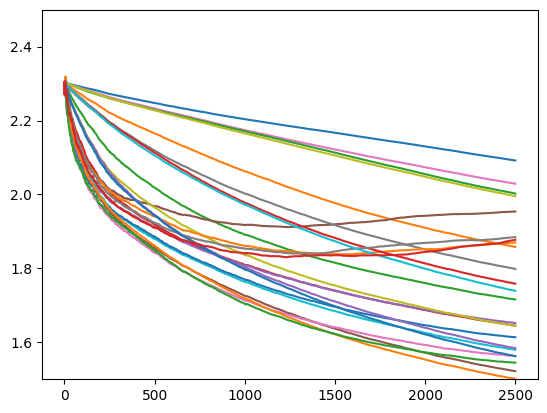

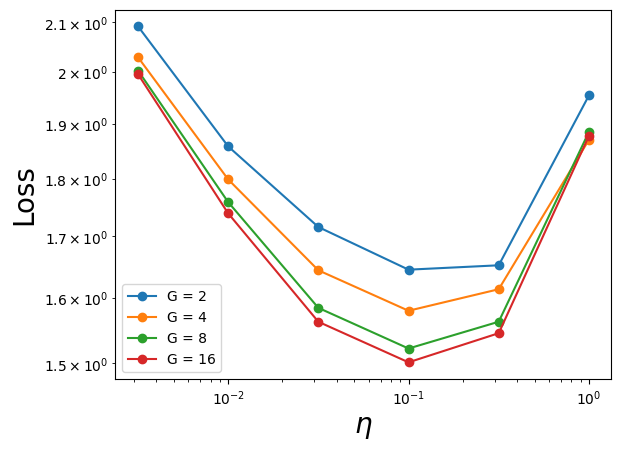

In [82]:
final_losses = []
for loss in all_losses:
    final_i = []
    for loss_eta in loss:
        plt.plot(loss_eta)
        final_i += [loss_eta[-1]]
    final_losses += [final_i]
plt.ylim([1.5,2.5])
plt.show()


for i,loss in enumerate(final_losses):
    plt.loglog(lrs, loss, '-o', label = f'G = {head_vals[i]}')
plt.legend()
plt.xlabel(r'$\eta$',fontsize = 20)
plt.ylabel(r'Loss', fontsize = 20)
plt.show()

# Implement ADAM

In [6]:

dimvals = [4, 8, 16, 32, 64]
depth = 4
heads = 4
patch_size = 4
scale_exp = 1.0

T = 2000
lr = 0.1
gamma = 0.8
batch = 64

opt_args = ( T, batch, gamma, lr )
all_losses = []
for i, dim in enumerate(dimvals):
    param_args = (dim, heads, depth, patch_size, scale_exp)
    print(" ")
    print(f"dim = {dim}")
    losses = train_model(param_args, opt_args, (X, y), adam = True)
    all_losses += [losses] 

 
dim = 4
 loss = 1.5709433555603027 
dim = 8
 loss = 1.5087578296661377 
dim = 16
 loss = 1.4715726375579834 
dim = 32
 loss = 1.4491610527038574 
dim = 64
 loss = 1.4471646547317505

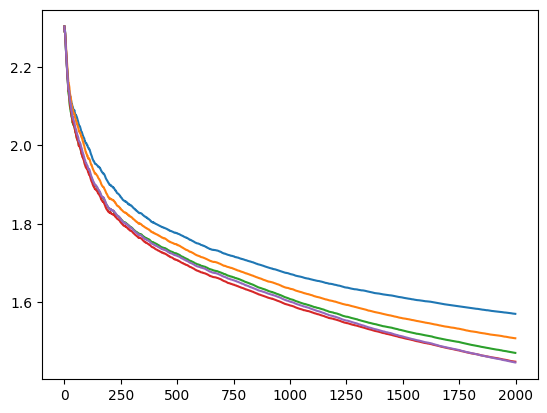

In [7]:
for loss in all_losses:
    plt.plot(loss)
plt.show()

In [1]:
dimvals = [4, 8, 16, 32]
depth = 6
heads = 4
patch_size = 4
scale_exp = 1.0

T = 1000
gamma = 1.0
batch = 64

lrs = jnp.logspace(-3.0, 0.6, 7)

all_losses = []
for i, dim in enumerate(dimvals):
    param_args = (dim, heads, depth, patch_size, scale_exp)
    print(" ")
    print(f"dim = {dim}")
    
    losses_i = []
    for j, lr in enumerate(lrs):
        opt_args = ( T, batch, gamma, lr )
        losses_i += [train_model(param_args, opt_args, (X, y), adam = True)]        
    all_losses += [losses_i] 

NameError: name 'jnp' is not defined

ValueError: x and y must have same first dimension, but have shapes (7,) and (6,)

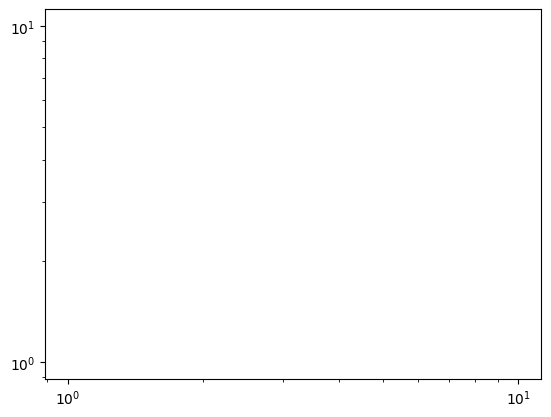

In [122]:

for i,loss in enumerate(final_losses):
    plt.loglog(lrs, loss, '-o', label = f'd = {dimvals[i]}')
plt.legend()
plt.xlabel(r'$\eta$',fontsize = 20)
plt.ylabel(r'Loss', fontsize = 20)
plt.title('HP Transfer Adam',fontsize = 20)
plt.tight_layout()
plt.show()

## Load Saved Results

In [1]:
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

class Args(argparse.Namespace):
    lr = 0.05
    mom = 0.0
    steps = 2500
    arch = 'vit'
    dataset = 'cifar5m'
    batch_size = 64
    scale_exp = 1.0
    depth = 2
    width = 16
    beta = 4.0
    gamma_zero = 0.1
    heads = 4
    

args = Args()


def get_run_name(args):
    return "model_{}/dataset_{}/lr_{:.4f}/mom_{:.2f}/batch_size_{}/steps_{}/width_{}/heads_{}/depth_{}/scale_exp_{}/beta_{}/gamma_zero_{}".format(args.arch, args.dataset, args.lr, args.mom, args.batch_size, args.steps, args.width, args.heads, args.depth, args.scale_exp, args.beta, args.gamma_zero)


save_dir = '/n/holyscratch01/pehlevan_lab/Users/bbordelon/bbordelon/Learn_gates/cifar_VIT'


## Head sweep 
lrs = np.logspace(-2.5,1.0,12)
heads = [4,8,16,32,64, 128]

all_losses = []
for i,head in enumerate(heads):
    loss_i = []
    for j,lr in enumerate(lrs):
        args.heads = head
        args.lr = lr
        run_name = get_run_name(args)
        save_path = os.path.join(save_dir, run_name.replace("/", "-"))
        
        loss_i += [np.load(save_path + '.npy')]
    all_losses += [loss_i]
    


all_losses_half = []
for i,head in enumerate(heads):
    loss_i = []
    for j,lr in enumerate(lrs):
        args.heads = head
        args.lr = lr
        args.scale_exp = 0.5
        run_name = get_run_name(args)
        save_path = os.path.join(save_dir, run_name.replace("/", "-"))
        
        loss_i += [np.load(save_path + '.npy')]
    all_losses_half += [loss_i]


In [39]:
final_losses =  [ [loss_ij[-1] for loss_ij in loss_i] for loss_i in all_losses ] 
final_losses_half =  [ [loss_ij[-1] for loss_ij in loss_i] for loss_i in all_losses_half ] 

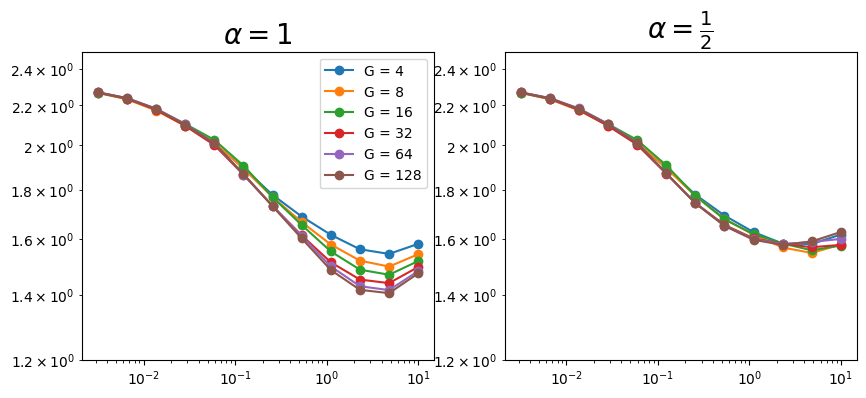

In [40]:
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)

for i,final_i in enumerate(final_losses):
    plt.loglog(lrs, np.array(final_i), '-o', label = f'G = {heads[i]}')
plt.ylim([1.2,2.5])
plt.legend()
plt.title(r'$\alpha = 1$',fontsize = 20)
plt.subplot(1,2,2)
plt.title(r'$\alpha = \frac{1}{2}$',fontsize = 20)
for final_i in final_losses_half:
    plt.loglog(lrs, np.array(final_i), '-o')
plt.ylim([1.2,2.5])
plt.show()

In [3]:

class Args(argparse.Namespace):
    lr = 0.05
    mom = 0.0
    steps = 20000
    arch = 'vit'
    dataset = 'cifar5m'
    batch_size = 64
    scale_exp = 1.0
    depth = 2
    width = 32
    beta = 4.0
    gamma_zero = 0.1
    heads = 4
    

args = Args()



## Head sweep 
lrs = np.logspace(-2.5,1.0,12)
heads = [4,8,16,32,64]

all_losses = []
for i,head in enumerate(heads):
    loss_i = []
    for j,lr in enumerate(lrs):
        args.heads = head
        args.lr = lr
        run_name = get_run_name(args)
        save_path = os.path.join(save_dir, run_name.replace("/", "-"))
        
        loss_i += [np.load(save_path + '.npy')]
    all_losses += [loss_i]
    


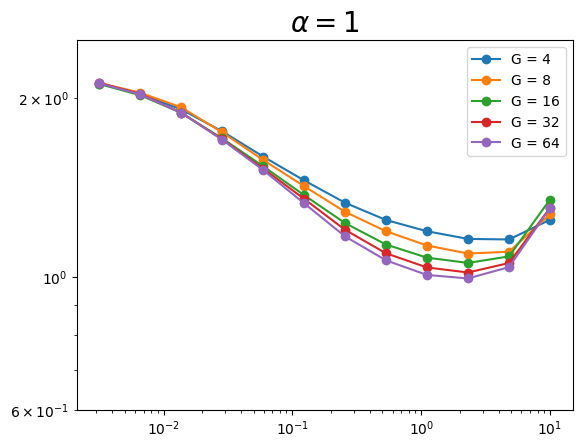

In [4]:
final_losses =  [ [loss_ij[-1] for loss_ij in loss_i] for loss_i in all_losses ] 

for i,final_i in enumerate(final_losses):
    plt.loglog(lrs, np.array(final_i), '-o', label = f'G = {heads[i]}')
plt.ylim([0.6,2.5])
plt.legend()
plt.title(r'$\alpha = 1$',fontsize = 20)
plt.show()

# LR Transfer Experiments

In [2]:
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


class Args(argparse.Namespace):
    lr = 0.05
    mom = 0.0
    steps = 75000
    arch = 'simple_TF'
    dataset = 'cifar5m'
    batch_size = 64
    scale_exp = 1.0
    depth = 2
    width = 32
    beta = 4.0
    gamma_zero = 0.25
    heads = 16

args = Args()


def get_run_name(args):
    return "model_{}/dataset_{}/lr_{:.4f}/mom_{:.2f}/batch_size_{}/steps_{}/width_{}/heads_{}/depth_{}/scale_exp_{}/beta_{}/gamma_zero_{}".format(args.arch, args.dataset, args.lr, args.mom, args.batch_size, args.steps, args.width, args.heads, args.depth, args.scale_exp, args.beta, args.gamma_zero)


save_dir = '/n/holyscratch01/pehlevan_lab/Users/bbordelon/bbordelon/Learn_gates/cifar_VIT'


lrs = np.logspace(-2.5,1.0,12)
widths = [4,8,16,32,64]


all_losses = []
for i,width in enumerate(widths):
    loss_i = []
    for j,lr in enumerate(lrs):
        args.width = width
        args.lr = lr
        run_name = get_run_name(args)
        save_path = os.path.join(save_dir, run_name.replace("/", "-"))
        
        loss_i += [np.load(save_path + '.npy')]
    all_losses += [loss_i]
    

all_losses_half = []
args.scale_exp = 0.5
for i,width in enumerate(widths):
    loss_i = []
    for j,lr in enumerate(lrs):
        args.width = width
        args.lr = lr
        run_name = get_run_name(args)
        save_path = os.path.join(save_dir, run_name.replace("/", "-"))
        
        loss_i += [np.load(save_path + '.npy')]
    all_losses_half += [loss_i]
    


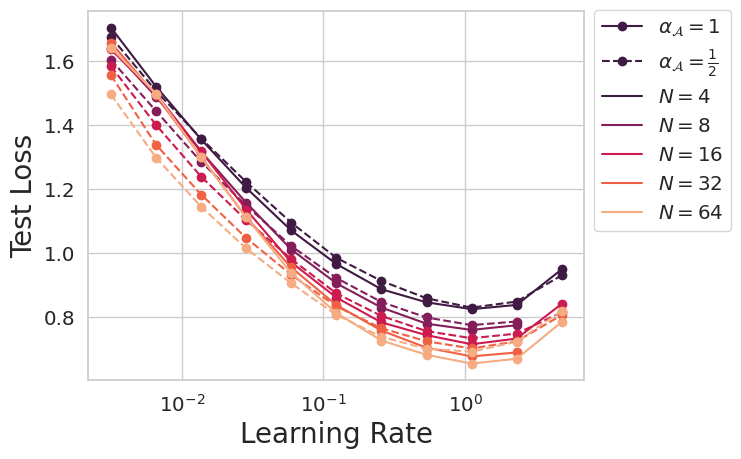

In [3]:
sns.set(font_scale=1.3)
sns.set_style("whitegrid")
sns.set_palette("rocket", n_colors=len(all_losses))

final_losses = [ [ np.mean(loss_ij[-50:-1]) for loss_ij in loss_i] for loss_i in all_losses]


final_losses_half = [ [np.mean(loss_ij[-50:-1]) for loss_ij in loss_i] for loss_i in all_losses_half]


for i,final_i in enumerate(final_losses):
    plt.semilogx(lrs, final_i, '-o', color = f'C{i}')
    plt.semilogx(lrs, final_losses_half[i], '--o', color = f'C{i}')
plt.plot([],[],'-o', color = f'C{0}',label = r'$\alpha_{\mathcal{A}} = 1$')
plt.plot([],[],'--o', color = f'C{0}',label = r'$\alpha_{\mathcal{A}} = \frac{1}{2}$')
for i, N in enumerate(widths):
    plt.plot([],[], color = f'C{i}', label = f'$N = {N}$')
plt.legend(bbox_to_anchor=(1.0, 1.03), loc='upper left')
plt.ylabel('Test Loss',fontsize = 20)
plt.xlabel('Learning Rate',fontsize = 20)
#plt.savefig(f'figures/LR_transfer_VIT_Cifar_vary_N_H_{args.heads}.pdf',bbox_inches = 'tight')
plt.show()

### Lazier and Deeper Example

In [4]:
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


class Args(argparse.Namespace):
    lr = 0.05
    mom = 0.0
    steps = 75000
    arch = 'simple_TF'
    dataset = 'cifar5m'
    batch_size = 64
    scale_exp = 1.0
    depth = 8
    width = 32
    beta = 8.0
    gamma_zero = 0.05
    heads = 16

args = Args()


def get_run_name(args):
    return "model_{}/dataset_{}/lr_{:.4f}/mom_{:.2f}/batch_size_{}/steps_{}/width_{}/heads_{}/depth_{}/scale_exp_{}/beta_{}/gamma_zero_{}".format(args.arch, args.dataset, args.lr, args.mom, args.batch_size, args.steps, args.width, args.heads, args.depth, args.scale_exp, args.beta, args.gamma_zero)


save_dir = '/n/holyscratch01/pehlevan_lab/Users/bbordelon/bbordelon/Learn_gates/cifar_VIT'


lrs = np.logspace(-2.5,1.0,12)
widths = [4,8,16,32,64]


all_losses = []
for i,width in enumerate(widths):
    loss_i = []
    for j,lr in enumerate(lrs):
        args.width = width
        args.lr = lr
        run_name = get_run_name(args)
        save_path = os.path.join(save_dir, run_name.replace("/", "-"))
        
        loss_i += [np.load(save_path + '.npy')]
    all_losses += [loss_i]
    

all_losses_half = []
args.scale_exp = 0.5
for i,width in enumerate(widths):
    loss_i = []
    for j,lr in enumerate(lrs):
        args.width = width
        args.lr = lr
        run_name = get_run_name(args)
        save_path = os.path.join(save_dir, run_name.replace("/", "-"))
        
        loss_i += [np.load(save_path + '.npy')]
    all_losses_half += [loss_i]
    


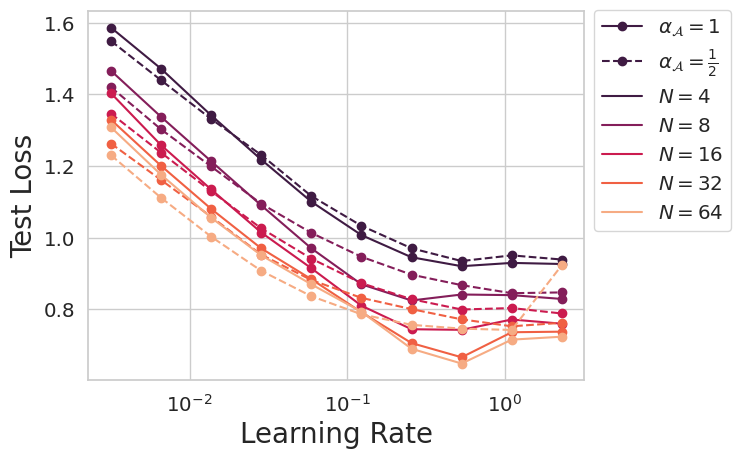

In [7]:
sns.set(font_scale=1.3)
sns.set_style("whitegrid")
sns.set_palette("rocket", n_colors=len(all_losses))

final_losses = [ [ np.mean(loss_ij[-10:-1]) for loss_ij in loss_i] for loss_i in all_losses]
final_losses_half = [ [np.mean(loss_ij[-10:-1]) for loss_ij in loss_i] for loss_i in all_losses_half]


for i,final_i in enumerate(final_losses):
    plt.semilogx(lrs, final_i, '-o', color = f'C{i}')
    plt.semilogx(lrs, final_losses_half[i], '--o', color = f'C{i}')
plt.plot([],[],'-o', color = f'C{0}',label = r'$\alpha_{\mathcal{A}} = 1$')
plt.plot([],[],'--o', color = f'C{0}',label = r'$\alpha_{\mathcal{A}} = \frac{1}{2}$')
for i, N in enumerate(widths):
    plt.plot([],[], color = f'C{i}', label = f'$N = {N}$')
plt.legend(bbox_to_anchor=(1.0, 1.03), loc='upper left')
plt.ylabel('Test Loss',fontsize = 20)
plt.xlabel('Learning Rate',fontsize = 20)
#plt.savefig(f'figures/LR_transfer_VIT_Cifar_vary_N_H_{args.heads}.pdf',bbox_inches = 'tight')
plt.show()

In [109]:
all_losses_vary_H = []
head_vals = [16,32,64,128, 256]
lrs = np.logspace(-2.5,1.0,12)[:-2]

args.scale_exp = 0.5
args.width = 4
for i,heads in enumerate(head_vals):
    loss_i = []
    for j,lr in enumerate(lrs):
        args.heads = heads
        args.lr = lr
        run_name = get_run_name(args)
        save_path = os.path.join(save_dir, run_name.replace("/", "-"))
        loss_i += [np.load(save_path + '.npy')]
    all_losses_vary_H += [loss_i]
    

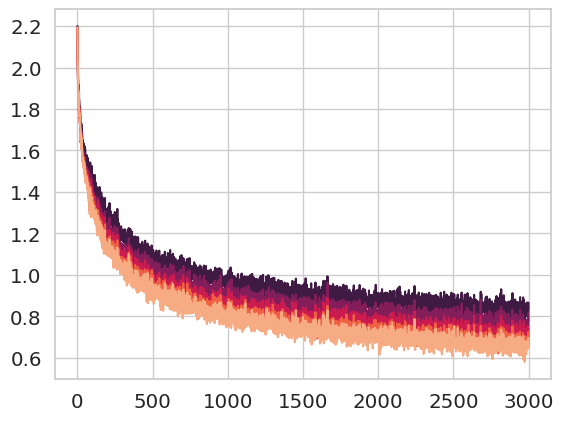

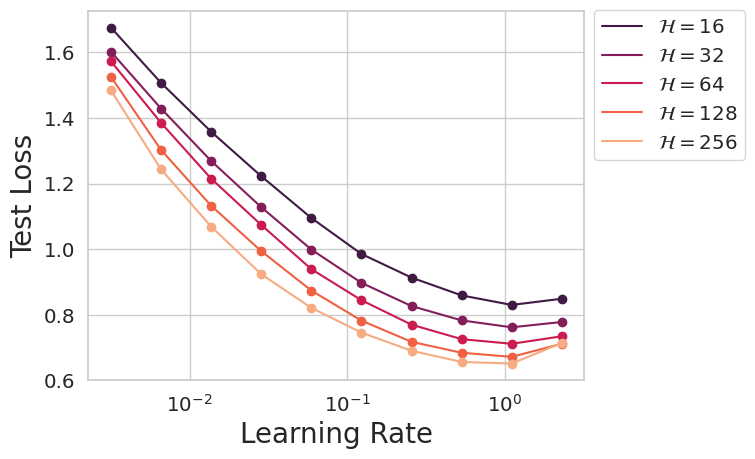

In [110]:
for i, loss_i in enumerate(all_losses_vary_H):
    plt.plot(loss_i[-2])
plt.show()

final_losses = [ [ np.mean(loss_ij[-50:-1]) for loss_ij in loss_i] for loss_i in all_losses_vary_H]


for i,final_i in enumerate(final_losses):
    plt.semilogx(lrs, final_i, '-o', color = f'C{i}')
#    plt.semilogx(lrs, final_losses_half[i], '--o', color = f'C{i}')
#plt.plot([],[],'-o', color = f'C{0}',label = r'$\alpha_{\mathcal{A}} = 1$')
#plt.plot([],[],'--o', color = f'C{0}',label = r'$\alpha_{\mathcal{A}} = \frac{1}{2}$')
for i, heads in enumerate(head_vals):
    plt.plot([],[], color = f'C{i}', label = r'$\mathcal{H} = %d$' % heads)
plt.legend(bbox_to_anchor=(1.0, 1.03), loc='upper left')
plt.ylabel('Test Loss',fontsize = 20)
plt.xlabel('Learning Rate',fontsize = 20)
#plt.savefig(f'figures/LR_transfer_VIT_Cifar_vary_N_H_{args.heads}.pdf',bbox_inches = 'tight')
plt.show()